# **Black-Scholes RK4 Numerical Solver**
In this notebook, I'll be numerically solving the Black-Scholes PDE, a fundamental equation in quantitative finance used to model the price evolution of European options. It describes how the value of an option ($V$) changes over time ($t$) and with respect to the underlying asset price ($S$), incorporating the effects of volatility ($\sigma$) and the risk-free interest rate ($r$). This will be used to benchmark and finetune the PINN which will be approximating the same equation.



---

$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0
$$
<center>

**Black-Scholes PDE**
</center>

Where:
* $V$: Option price
* $t$: Time
* $S$: Price of the underlying asset
* $\sigma$: Volatility of the underlying asset's returns
* $r$: Risk-free interest rate

---



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

# Define parameters
r = 0.05          # Risk-free rate
sigma = 0.2       # Volatility
K = 100           # Strike price
T = 1.0           # Time to maturity (in years)
S_max = 250       # Max stock price in spatial domain
S_min = 0         # Min stock price
N = 500           # Number of spatial grid points

# Discretize stock price (space)
S = np.linspace(S_min, S_max, N)
dS = S[1] - S[0]

# Initial condition at maturity for European call option
V_T = np.maximum(S - K, 0)

# Define rhs of PDE
def black_scholes_rhs(t, V):
    dVdt = np.zeros_like(V)

    for i in range(1, N-1):
        delta = (V[i+1] - V[i-1]) / (2*dS)
        gamma = (V[i+1] - 2*V[i] + V[i-1]) / (dS**2)
        
        dVdt[i] = -0.5 * sigma**2 * S[i]**2 * gamma \
                  - r * S[i] * delta + r * V[i]

    # Boundary conditions
    dVdt[0] = 0  # V=0 at S=0
    dVdt[-1] = r * (S[-1] - K) - r * V[-1]  # linear payoff behavior at high S

    return dVdt

# Reverse time interval: solve backward from maturity
sol = solve_ivp(
    fun=black_scholes_rhs,
    t_span=[T, 0],            # backward integration
    y0=V_T,                   # initial value at maturity
    t_eval=np.linspace(T, 0, 200),  # time points to evaluate
    method='RK45'
)

## **Lineplot**

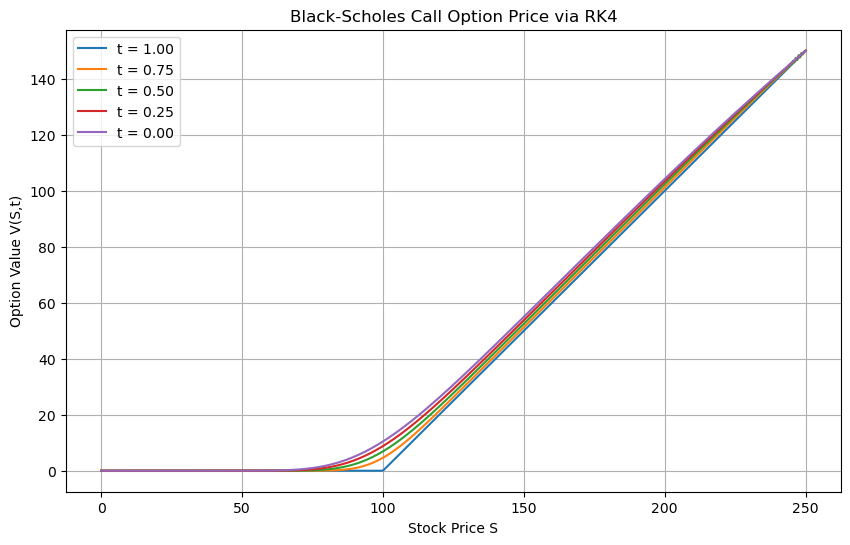

In [11]:
# Pick time slices to visualize
plt.figure(figsize=(10, 6))
for idx in [0, 50, 100, 150, 199]:
    plt.plot(S, sol.y[:, idx], label=f"t = {sol.t[idx]:.2f}")
plt.title("Black-Scholes Call Option Price via RK4")
plt.xlabel("Stock Price S")
plt.ylabel("Option Value V(S,t)")
plt.legend()
plt.grid(True)
plt.show()

## **Heatmap**

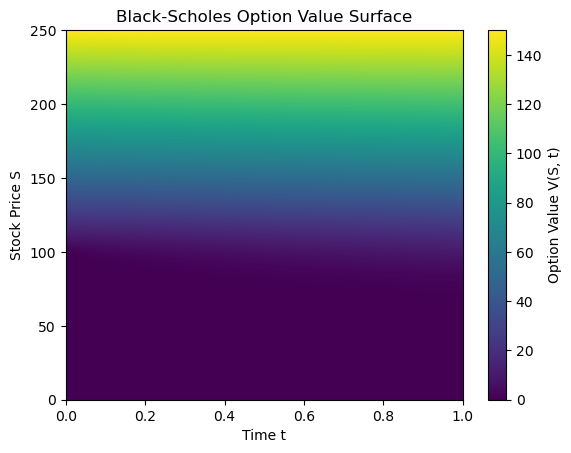

In [ ]:
plt.imshow(sol.y, extent=[0, T, S_min, S_max], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Option Value V(S, t)')
plt.xlabel('Time t')
plt.ylabel('Stock Price S')
plt.title('Black-Scholes Option Value Surface')
plt.show()

## **3D Surface Plot**

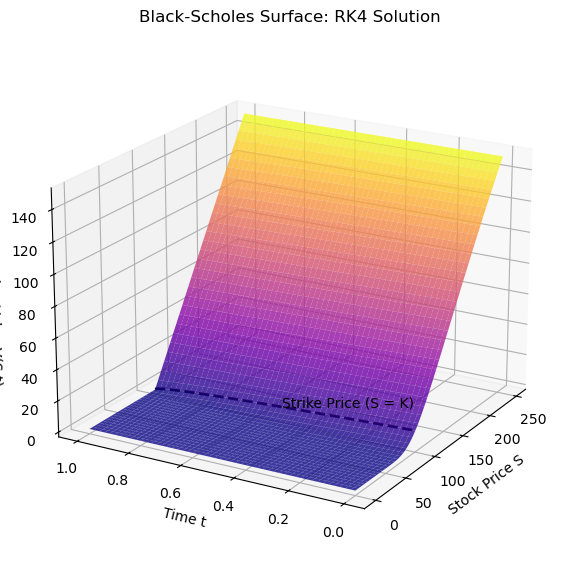

In [13]:
from mpl_toolkits.mplot3d import Axes3D

S_grid, T_grid = np.meshgrid(S, sol.t)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, sol.y.T, cmap='plasma', alpha=0.8, edgecolor='none')

# Find strike price index
strike_idx = np.argmin(np.abs(S - K))
V_strike = sol.y[strike_idx, :]  # V(S=K, t) across time

# Plot the at-the-money slice
ax.plot(
    [S[strike_idx]] * len(sol.t),  # S is constant
    sol.t,                         # time axis
    V_strike,                      # value at S = K
    color='black',
    linewidth=2,
    linestyle='--',
    label=f'At-the-money (S = K = {K})'
)

# Add annotation label
ax.text(
    S[strike_idx],                # S location
    0.5,                          # t = 0.5 (middle)
    V_strike[len(sol.t)//2],     # value at mid-time
    'Strike Price (S = K)', 
    color='black', fontsize=10
)

# Labels and view angle
ax.set_xlabel('Stock Price S')
ax.set_ylabel('Time t')
ax.set_zlabel('Option Value V(S,t)')
ax.set_title('Black-Scholes Surface: RK4 Solution')
ax.view_init(elev=20, azim=210)

plt.show()

## **Build Dataframe**

In [15]:
# Repeat each stock price for every time step
all_S = np.repeat(S, len(sol.t))  # Shape: (N * T,)

# Tile the time grid for each stock price
all_t = np.tile(sol.t, len(S))    # Shape: (N * T,)

# Flatten the solution V(S, t) array (which is already S-major ordering)
all_V = sol.y.flatten()

# Combine into DataFrame
df = pd.DataFrame({
    'S': all_S,
    't': all_t,
    'V': all_V
})

df.tail(25)

,S,t,V
99975,250.0,0.120603,150.0
99976,250.0,0.115578,150.0
99977,250.0,0.110553,150.0
99978,250.0,0.105528,150.0
99979,250.0,0.100503,150.0
99980,250.0,0.095477,150.0
99981,250.0,0.090452,150.0
99982,250.0,0.085427,150.0
99983,250.0,0.080402,150.0
99984,250.0,0.075377,150.0
